## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

## Load Dataset

In [2]:
# load dataset use yfinance (btc)
df = yf.download(tickers='BTC-USD', period='5y', interval='1d') # take 5 years period
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2019-12-25,7275.155762,7275.155762,7357.020020,7220.991211,7325.755859,21559505149
2019-12-26,7238.966797,7238.966797,7388.302734,7200.386719,7274.799316,22787010034
2019-12-27,7290.088379,7290.088379,7363.529297,7189.934082,7238.141113,22777360996
2019-12-28,7317.990234,7317.990234,7399.041016,7286.905273,7289.031250,21365673026
2019-12-29,7422.652832,7422.652832,7513.948242,7279.865234,7317.647461,22445257702


In [3]:
# info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2019-12-25 to 2024-12-25
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BTC-USD)  1827 non-null   float64
 1   (Close, BTC-USD)      1827 non-null   float64
 2   (High, BTC-USD)       1827 non-null   float64
 3   (Low, BTC-USD)        1827 non-null   float64
 4   (Open, BTC-USD)       1827 non-null   float64
 5   (Volume, BTC-USD)     1827 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 99.9 KB


In [4]:
# take open for time series
df = df[['Open']]
df[:5]

Price,Open
Ticker,BTC-USD
Date,
2019-12-25,7325.755859
2019-12-26,7274.799316
2019-12-27,7238.141113
2019-12-28,7289.031250
2019-12-29,7317.647461


In [5]:
# check the last date in the dataset
df.index[-1]

Timestamp('2024-12-25 00:00:00')

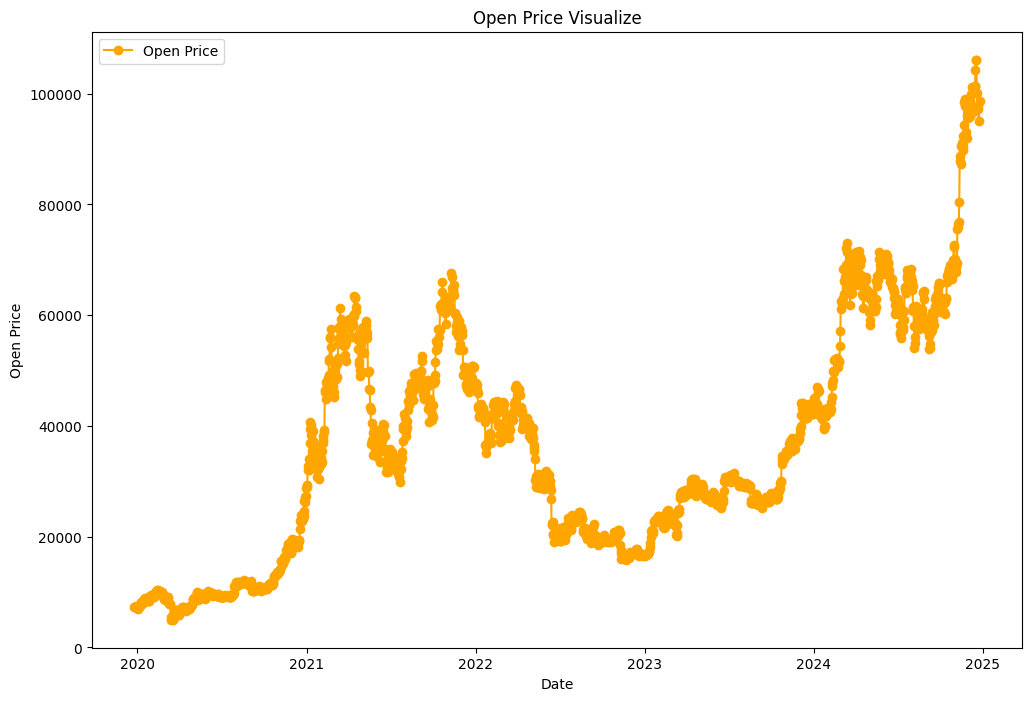

In [6]:
# plot open price for last 1y
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Open'], label='Open Price', marker='o', linestyle='-', color='orange')
plt.title('Open Price Visualize')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

In [7]:
# scaled of data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# split the data into training and testing sets
train_len_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[:train_len_size], df_scaled[train_len_size:]

In [8]:
# prepare the input and output sequences
def create_sequences(data, seq_len):
  x, y = [], []
  for i in range(len(data) - seq_len):
    x.append(data[i:(i + seq_len), 0])
    y.append(data[i + seq_len, 0])
  return np.array(x), np.array(y)

seq_len = 10
X_train, y_train = create_sequences(train_data, seq_len)
X_test, y_test = create_sequences(test_data, seq_len)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# build LSTM model
model = Sequential([
    LSTM(50, input_shape=(seq_len, 1), return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(10),
    Dense(1)
])

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# summary model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,121 (121.57 KB)

 Trainable params: 31,121 (121.57 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# create callbacks obj
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
# fit the lstm model
history = model.fit(X_train, y_train, epochs=10, batch_size=5, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.9925e-04 - val_loss: 0.0021
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.0593e-04 - val_loss: 0.0034
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.0430e-04 - val_loss: 0.0015
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.5045e-04 - val_loss: 8.1385e-04
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.0205e-04 - val_loss: 9.6418e-04
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.9556e-04 - val_loss: 0.0011
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9051e-04 - val_loss: 4.3086e-04
Epoch 9/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.3595e-04 - val_loss: 8.3171e-04
Epoch 10/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2.1062e-04 - val_loss: 5.5919e-04


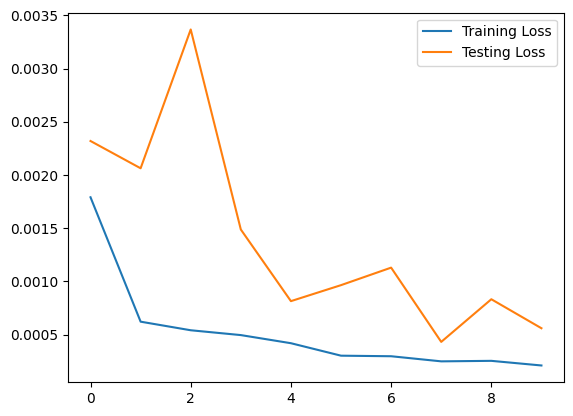

In [11]:
# plot history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.show()

In [12]:
# predict on the test set
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
len(y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


356

In [13]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

64062.40638743466

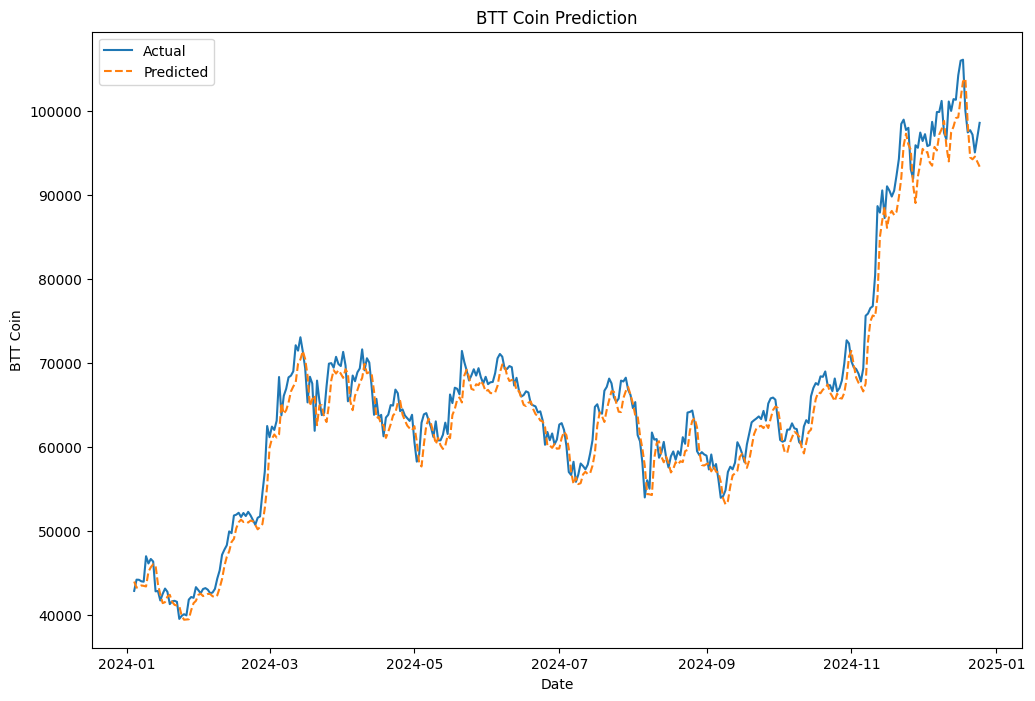

In [14]:
# plot the prediction
plt.figure(figsize=(12, 8))
plt.plot(df.index[-len(y_pred):], df[-len(y_pred):]['Open'], label='Actual')
plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted', linestyle='dashed')
plt.title('BTT Coin Prediction')
plt.xlabel('Date')
plt.ylabel('BTT Coin')
plt.legend()
plt.show()

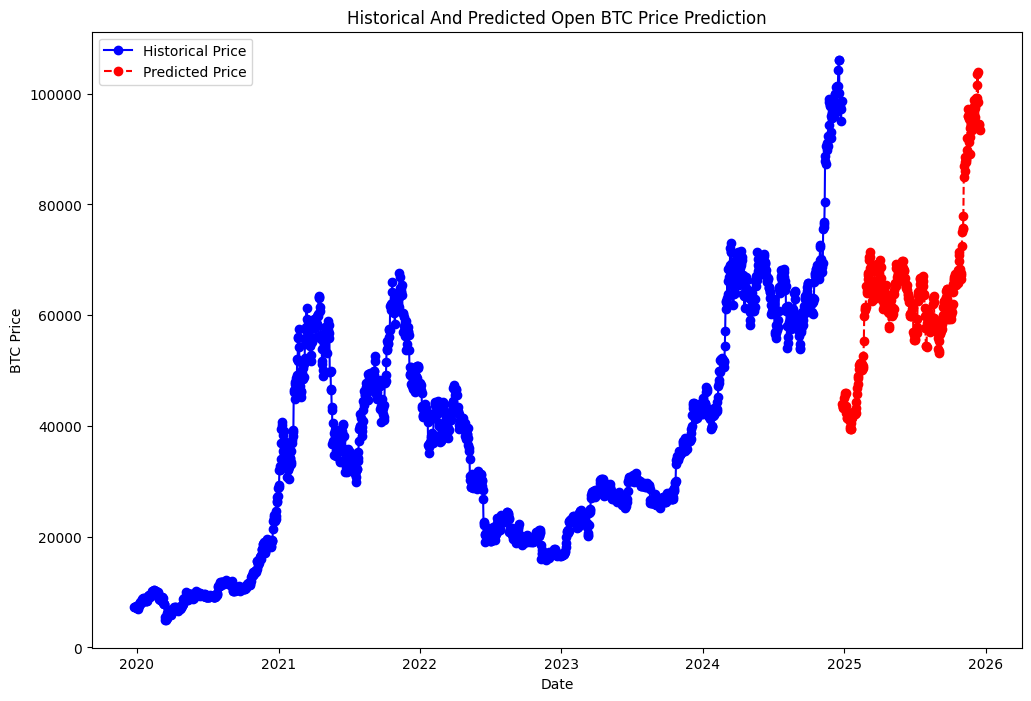

In [19]:
# plot historical
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Open'], label='Historical Price', marker='o', linestyle='-', color='b')

# plot prediction
pred_date = pd.date_range(start=df.index[-1], periods=len(y_pred)+1, freq='D')[1:]
plt.plot(pred_date, y_pred, label='Predicted Price', marker='o', linestyle='dashed', color='r')

plt.title('Historical And Predicted Open BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.show()